In [27]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from copy import copy
from datetime import datetime

In [32]:
def rgb2gray(rgb):
    """ Convert an RGB image to grayscale. """
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

@jit
def array_helper():
    return np.zeros(255, dtype=np.int32)

@cuda.autojit
def window_hist(img, center_pixel_val, slider_len):
    """ Calculate new pixel value for the center pixel
    in an image window for adaptive histogram equalization. """
    
    pixel_freq = np.zeros(255, dtype=np.float64)
    pdf = np.zeros(255, dtype=np.float64)
    cdf = np.zeros(255, dtype=np.float64)
    pixel_unique = []
    
    if slider_len is not None:
        pixel_count = slider_len[0] * slider_len[1]
        slider_len = (slider_len[0]-1, slider_len[1]-1)
    else:
        pixel_count = len(img) * len(img[0])
        slider_len = (len(img[0]), len(img))
    
    # for each pixel in the window update pixel frequency
    for i in range(slider_len[1]):
        for j in range(slider_len[0]):
            pixel_val = img[i, j]
            pixel_freq[pixel_val] += 1
            if pixel_val not in pixel_unique:
                pixel_unique.append(pixel_val)
                
    pixel_unique.sort()
                
    # for each pixel value, calculate its probability
    for pixel_val in pixel_unique:
        pdf[pixel_val] = pixel_freq[pixel_val] / pixel_count
    
    # for each pixel value, update cdf
    prev = 0
    for pixel_val in pixel_unique:
        prob = pdf[pixel_val]
        cdf[pixel_val] = prev + prob
        prev = cdf[pixel_val]
        cdf[pixel_val] = round(cdf[pixel_val] * 250)
        
        # once the cdf reaches the target pixel, no need to continue
        if pixel_val == center_pixel_val:
            break
        
    return cdf[center_pixel_val]

def adaptive_hist_eq_cuda(img, slider_len):
    """ Apply sliding window adaptive histogram equalization to an image
    for improved local contrast. """
    
    # make a copy of original to replace pixels
    final_img = copy(img)
    n = len(img)
    m = len(img[0])

    gap = int(slider_len[0]// 2)  # left and right shifts
    
    for i in range(gap):
        for j in range(gap, m-gap):
            center_pixel_val = img[i, j]
            final_img[i, j] = window_hist(img[:i+gap,j-gap:j+gap], center_pixel_val, None)
            
    for i in range(n-gap, n):
        for j in range(gap, m-gap):
            center_pixel_val = img[i, j]
            final_img[i, j] = window_hist(img[i-gap:n,j-gap:j+gap], center_pixel_val, None)
            
    for i in range(gap, n-gap):
        for j in range(gap):
            center_pixel_val = img[i, j]
            final_img[i, j] = window_hist(img[i-gap:i+gap,:j+gap], center_pixel_val, None)
            
    for i in range(gap, n-gap):
        for j in range(m-gap, m):
            center_pixel_val = img[i, j]
            final_img[i, j] = window_hist(img[i-gap:i+gap,j-gap:m], center_pixel_val, None)
            
    for i in range(gap):
        for j in range(gap):
            center_pixel_val = img[i, j]
            final_img[i, j] = window_hist(img[:i+gap,:j+gap], center_pixel_val, None)
    
    for i in range(n-gap, n):
        for j in range(m-gap, m):
            center_pixel_val = img[i, j]
            final_img[i, j] = window_hist(img[i-gap:,j-gap:], center_pixel_val, None)
            
    for i in range(n-gap, n):
        for j in range(gap):
            center_pixel_val = img[i, j]
            final_img[i, j] = window_hist(img[i-gap:,:j+gap], center_pixel_val, None)
            
    for i in range(gap):
        for j in range(m-gap, m):
            center_pixel_val = img[i, j]
            final_img[i, j] = window_hist(img[:i+gap,j-gap:], center_pixel_val, None)
    
    # for each pixel in the center of the image, apply adaptive histogram equalization
    for i in range(gap, n - gap):
        for j in range(gap, m - gap):
            center_pixel_val = img[i, j]
            final_img[i, j] = window_hist(img[i-gap:i+gap, j-gap:j+gap], center_pixel_val, slider_len)

    return final_img.astype(int)


/home/brian/anaconda3/lib/python3.6/site-packages/numba/cuda/decorators.py:113: UserWarning: autojit is deprecated and will be removed in a future release. Use jit instead.
  warn('autojit is deprecated and will be removed in a future release. Use jit instead.')


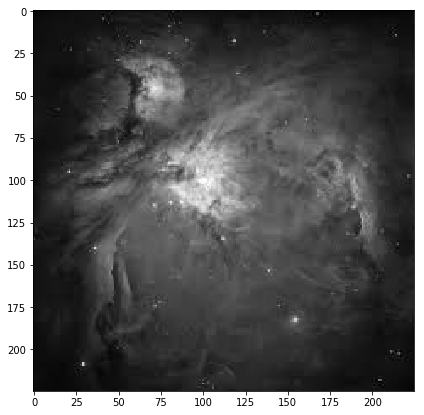

In [3]:
# original image
img = plt.imread("test_image3.jpeg")
gray = rgb2gray(img)
clean_image = np.matrix.round(gray).astype(int)
plt.figure(figsize=(13,7))
plt.imshow(clean_image, cmap=plt.get_cmap('gray'))
plt.show()

In [33]:
# normal histogram equalization
plt.figure(figsize=(13,7))
plt.imshow(adaptive_hist_eq_cuda(clean_image, (30, 30)), cmap=plt.get_cmap('gray'))
plt.show()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mUse of unsupported NumPy function 'numpy.zeros' or unsupported use of the function.
[1m
File "<ipython-input-32-b82b966d6063>", line 14:[0m
[1mdef window_hist(img, center_pixel_val, slider_len):
    <source elided>
    
[1m    pixel_freq = np.zeros(255, dtype=np.float64)
[0m    [1m^[0m[0m
[0m
[0m[1m[1] During: typing of get attribute at <ipython-input-32-b82b966d6063> (14)[0m
[1m
File "<ipython-input-32-b82b966d6063>", line 14:[0m
[1mdef window_hist(img, center_pixel_val, slider_len):
    <source elided>
    
[1m    pixel_freq = np.zeros(255, dtype=np.float64)
[0m    [1m^[0m[0m


<Figure size 936x504 with 0 Axes>

In [18]:
np.int32

numpy.int32